In [75]:
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import random
from matplotlib import pyplot
from random import randrange

import matplotlib.cm as cm #Used to display images in a specific colormap
from scipy.optimize import fmin_bfgs

In [76]:
mat = scipy.io.loadmat('machine-learning-ex4\ex4\ex4data1.mat')
X = mat['X']
y = mat['y'].flatten()
y[y==10]=0
m = y.size

thetas = scipy.io.loadmat('machine-learning-ex4\ex4\ex4weights.mat')
theta1 = thetas['Theta1']
theta2 = thetas['Theta2']
theta = np.concatenate((theta1.ravel(),theta2.ravel()),axis=0)

In [77]:
# THE FOLLOWING BLOCK WAS FOUND USING ONLINE RESOURCE 

def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        # Display Image
        h = ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                      cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

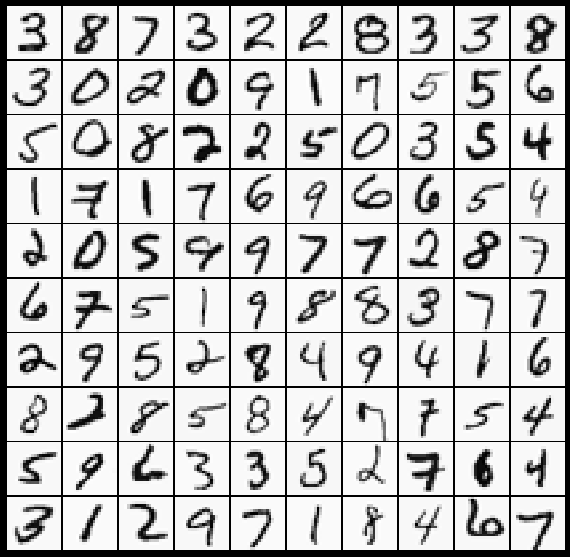

In [78]:
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]
displayData(sel)

In [105]:
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10


def sigmoid(x):
    return(1 / (1 + np.exp(-x)))

def predict(theta1,theta2,X):
    if(X.shape==1):
        X = X[:,np.newaxis]
    X = np.append(1,X)

    hidden = np.zeros((hidden_layer_size,1))
    hidden = theta1.dot(X)
    hidden = sigmoid(hidden)

    hidden = np.append(1,hidden)
    output = theta2.dot(hidden)
    return sigmoid(output)

def turnNumToVector(x):
    ret = np.zeros((num_labels))
    ret[x]=1
    return ret

def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, lambda_=0.0):

    theta1size = (input_layer_size+1)*hidden_layer_size

    theta1 = np.reshape(nn_params[0:theta1size],(25,401))
    theta2 = np.reshape(nn_params[theta1size:theta1size+(hidden_layer_size+1)*10],(10,26))
    hx = np.zeros((10,m))
    hy = np.zeros((10,m))
    
    for sub in range(0,m):
        hx[:,sub]=predict(theta1,theta2,X[sub])
        hy[:,sub]=turnNumToVector(y[sub])
    J = 0
    for i in range(0,num_labels):
        print(hy[i,:].shape)
        J += -np.log(hx[i,:]).T.dot(hy[i,:])-np.log(1-hx[i,:]).T.dot(1-hy[i,:])
    # J += lambda_/(2*m)*(sum(np.power(theta[1:],2)))
    return float(J)/m

    




nnCostFunction(theta.ravel(),input_layer_size,hidden_layer_size,num_labels,X,y)


(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)


10.44145967277798